# Sieci splotowe

In [48]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Przygotowanie danych
Ponownie wykorzystamy w zadaniu zbiór MNIST. Zaczynamy od pobrania dnaych.

In [49]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

target_directory = "mnist"

mnist_real_train = MNIST(target_directory, train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(target_directory, train=False, download=True, transform=transforms.ToTensor())

In [50]:
mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))
len(mnist_train), len(mnist_validation)

(48000, 12000)

In [51]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [52]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

## Budowa sieci neuronowej

### Warstwa splotowa

Warstwa splotowa (ang. *convolutional layer*) przesuwa jądro (ang. *kernel*) po obrazie (w ogólności: po macierzy) miejsce przy miejscu, oblicza wynik i zapamiętuje w macierzy wyjściowej. Na poniższym rysunku mamy do czynienia z obrazem $7\times 5$ pikseli (jasnoszary obszar w dolnej części rysunku) po którym przesuwane jest jądro $3\times 3$ piksele. Obrazek jest uzupełniony (ang. *padding*) o zera, zaznaczone na rysunku kolorem ciemnoszarym. Po co takie uzupełnienie? Bez niego macierz wynikowa byłaby mniejsza niż obrazek wejściowy. Czerwony piksel w macierzy wyjściowej obliczany jest następująco: każdy z pikseli obrazu wejściowego jest mnożony przez odpowiadającą mu wartość w filtrze, a tak uzyskane 9 wartości jest sumowane. Następnie ten sam filtr wykorzystywany jest do obliczenia kolejnego piksela - zaznaczonego na niebiesko - na podstawie pikseli wejściowych zaznaczonych niebieską linią przerywaną. Filtr to są wagi splotowej sieci neuronowej, to znaczy to on podlega uczeniu.

![Rysunek poglądowy dotyczący warstwy splotowej](https://i.ibb.co/8KYF5TG/mlst-1303.png)

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

Jądro nie musi przsuwać się za każdym razem o 1 piksel, może mieć większy krok (ang. *stride*), jak na poniższym rysunku.

![Ilustracja *stride*](https://i.ibb.co/mHbnBns/mlst-1304.png)

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

Ale, ale... przecież obrazki mogą być kolorowe! No i faktycznie, możemy pojedynczy postrzegać pojedynczy obrazek jako kilka obrazków monochromatycznych. Wtedy zamiast przesuwać płaski filtr po pojedynczym obrazku przesuwamy kostkę, której dwa wymiary możemy modyfikować (odpowiedzialne za wysokość i szerokość), natomiast jej głębokość jest ustalona - zależy od liczby warstw obrazka. Na poniższym rysunku zaczynamy od normalnego obrazka RGB, który następnie jest zamieniany na wiele map - każda posiadająca swój jeden filtr (kostkę) - w ten sposób powstaje nowy "obrazek" podpisany na rysunku *Convolutional layer 1*, na którym... ponawiamy operację! Używając nowego zestawu filtrów tworzymy *Convolutional layer 2*.

![Ilustracja sieci splotowej w przypadku trójwymiarowym](https://i.ibb.co/0X1GTRL/mlst-1306.png)

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

Warstwę splotową w PyTorch realizuje klasa [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d). Pierwsze trzy parametry jej konstruktora są obowiązkowe, to kolejno: liczba map na wejściu, liczba map na wyjściu, rozmiar jądra (jedna liczba jeżeli ma być kwadratowe albo para liczb jeżeli ma być prostokątem).

Będziemy budowali krok po kroku tablicę `layers`, której będziemy umieszczali kolejne warstwy naszej sieci neuronowej.
Rozpoczniemy od dodania warstwy splotowej.
Obrazki MNIST są monochromatyczne, więc mamy tylko 1 kanał wejściowy.
Przyjmimy, że na wyjściu będziemy mieli 5 map, każdą na bazie kwadratowego filtra o boku 3.
Żeby nie zmniejszyć zbyt szybko obrazka dodamy po 1 pikselu paddingu z każdej strony - jak na rysunku powyżej.

In [53]:
layers = [
    nn.Conv2d(1, 5, 3, padding=1)
]

### Nieliniowość

Warstwa splotowa - podobnie jak warstwa liniowa (`nn.Linear`) - jest tylko sumą. Nie ma sensu bezpośrednie składanie kilku warstw splotowych jedna na drugą, potrzebna jest nieliniowość. Zastosujemy *leaky ReLU*, funkcję aktywacji przedstawioną na poniższym wykresie

![Leaky ReLU](https://i.ibb.co/DMfRk0y/leaky-relu.png)

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

In [54]:
layers.append(nn.LeakyReLU())

### Łączenie

Sieć splotowa pozwala uwydatnić pewne cechy w obrazie, na przykład na poniższym rysunku na mapie po lewej stronie uwydatnione zostały linie pionowe, a po prawej linie poziome. 

![](img/mlst_1305.png)

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

Z drugiej strony to uwydatnienie spowodowało, że trochę straciliśmy szczegóły i właściwie nie potrzebujemy już tak dużej rozdzielczości. Z pomocą przychodzi operacja łączenia (ang. *pooling*), która podobnie jak sieć splotowa przesuwa filtr przez obraz, ale ten filtr jest pozbawiony parametrów: służy albo do wybierania maksimum (ang. *max pooling*) albo do obliczania średniej arytmetycznej (ang. *average pooling*). Poniższy rysunek zgrubnie prezentuje ideę *max pooling* (kernel $2\times 2$, stride 2, bez paddingu - stąd $\times$ w ostatniej kolumnie). W przypadku łączenia nie ma problemu z przejściem do obrazów kolorowych - każda mapa analizowana jest oddzielnie, więc zawsze pozostajemy w dwóch wymiarach.

![max pooling](https://i.ibb.co/G3mDGCL/mlst-1308.png)

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

Dodamy do naszej sieci neuronowej *max pooling*, realizowany za pomocą klasy `nn.MaxPool2d`, z jądrem rozmiaru $3\times 3$ i uzupełnieniem o 1 piksel z każdej strony.

In [55]:
layers.append(nn.MaxPool2d(3, padding=1))

### Zadanie 1

Ile map i jakiego rozmiaru będzie na tym etapie przetwarzania, jeżeli wejście miało jedną mapę rozmiaru $28\times 28$?

* **Liczba map**: 5
* **Rozmiar każdej mapy**: 26x26

(28x28)*(3x3)=(28-3+1)x(28-3+1)

### Spłaszczanie

Na tym etapie każdy obiekt przetwarzany przez naszą sieć neuronową jest trójwymiarowy, tj. składa się z pewnej liczby dwuwymiarowych map. Takiego wejścia nie możemy podać do warstwy liniowej! Wykorzystamy klasę `nn.Flatten`, żeby ułożyć piksele jeden za drugim w formie wektora.

In [56]:
layers.append(nn.Flatten())

### Zadanie 2: Warstwa liniowa

Tak samo jak na poprzednich zajęciach wykorzystamy do klasyfikacji warstwę `nn.Linear`. Klasyfikujemy do 10 klas, więc musimy mieć 10 neuronów, ale ilu wejść potrzebujemy? Uzupełnij poprzedni kod na podstawie wyników zadania 1.

In [57]:
layers.append(nn.Linear(500, 10))

### Faktyczna budowa sieci neuronowej

Warstwy połączymy w jeden moduł wykorzystując klasę `nn.Sequential`, jako funkcję straty wykorzystamy entropię krzyżową, a do optymalizacji optymalizator Adam.

In [58]:
model = nn.Sequential(*layers)

cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [59]:
model

Sequential(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=500, out_features=10, bias=True)
)

## Uczenie z wykorzystaniem wczesnego zatrzymania

Wczesne zatrzymanie (ang. *early stopping*) polega na tym, że co określoną liczbę epok uczenia obliczamy miarę oceny (np. trafność klasyfikacji) na zbiorze walidującym. Jeżeli nastąpiła poprawa w stosunku do poprzedniego razu, to zapamiętujemy obecne wartości wag sieci neuronowej, jeżeli zaś przez kilka razy nie następuje poprawa, to przerywamy uczenie i przywracamy wagi ostatniego najlepszego modelu.

Poniższy kawałek kodu oblicza trafność na zbiorze walidującym co epokę i przerywa uczenie jeżeli przez 5 kolejnych epok nie nastąpiła poprawa.

In [60]:
train_loss = []
validation_acc = []
best_model = None
best_acc = None
best_epoch = None
max_epoch = 10000
no_improvement = 5
batch_size = 512

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)
    if best_acc is None or acc > best_acc:
        print("New best epoch ", n_epoch, "acc", acc)
        best_acc = acc
        best_model = model.state_dict()
        best_epoch = n_epoch
    if best_epoch + no_improvement <= n_epoch:
        print("No improvement for", no_improvement, "epochs")
        break
        
model.load_state_dict(best_model)

New best epoch  0 acc tensor(0.8363)
New best epoch  1 acc tensor(0.8873)
New best epoch  2 acc tensor(0.9076)
New best epoch  3 acc tensor(0.9180)
New best epoch  4 acc tensor(0.9264)
New best epoch  5 acc tensor(0.9333)
New best epoch  6 acc tensor(0.9381)
New best epoch  7 acc tensor(0.9421)
New best epoch  8 acc tensor(0.9449)
New best epoch  9 acc tensor(0.9483)
New best epoch  10 acc tensor(0.9493)
New best epoch  11 acc tensor(0.9531)
New best epoch  12 acc tensor(0.9562)
New best epoch  14 acc tensor(0.9569)
New best epoch  15 acc tensor(0.9584)
New best epoch  16 acc tensor(0.9597)
New best epoch  18 acc tensor(0.9599)
New best epoch  19 acc tensor(0.9620)
New best epoch  20 acc tensor(0.9631)
New best epoch  21 acc tensor(0.9632)
New best epoch  22 acc tensor(0.9635)
New best epoch  23 acc tensor(0.9659)
New best epoch  24 acc tensor(0.9665)
New best epoch  28 acc tensor(0.9669)
New best epoch  29 acc tensor(0.9670)
New best epoch  30 acc tensor(0.9682)
New best epoch  34 acc

<All keys matched successfully>

Przyjrzyj się poniższym wykresom

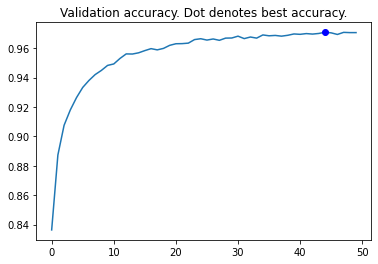

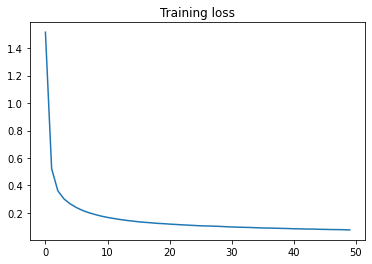

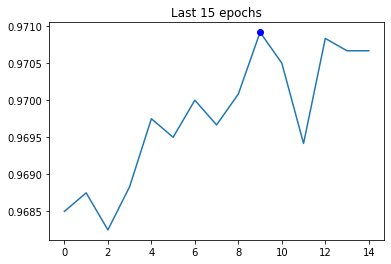

In [61]:
plt.title('Validation accuracy. Dot denotes best accuracy.')
plt.plot(validation_acc, label='Validation accuracy')
plt.plot(best_epoch, best_acc, 'bo', label='Best accuracy')
plt.show()
plt.title('Training loss')
plt.plot(train_loss)
plt.show()
k = max(3*no_improvement, 0)
plt.title('Last {} epochs'.format(k))
plt.plot(validation_acc[-k:])
plt.plot(best_epoch-(len(validation_acc)-k), best_acc, 'bo')
plt.show()

### Zadanie 3
Dlaczego wczesne zatrzymanie jest realizowane na zbiorze walidującym, a nie na zbiorze uczącym albo na zbiorze testowym?

**Tu miejsce na odpowiedź:** Zbiór walidujący pozwala ocenić błąd przeuczenia, co jest istotne przy określeniu wczesnego zatrzymania.

### Zadanie 4

Oblicz trafność klasyfikacji na zbiorze walidującym i na zbiorze testowym. Czy uzyskane wartości się różnią? W którą stronę? Dlaczego tak może być?

In [74]:
loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
X, y = next(iter(loader))
logits = model(X)
compute_acc(logits, y).detach()

tensor(0.9707)

**A tu napisz komentarz**

## Zadanie do samodzielnego wykonania

Zaimplementuj sieć o architekturze zbliżonej do [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), zgodnie z poniższym opisem:

|Nr warstwy|Typ|Rozmiar wyjścia|Liczba filtrów|Rozmiar jądra (`kernel_size`)|Krok (`stride`)|Padding|Funkcja aktywacji|
|----------|---|---------------|--------------|-----------------------|---------------|-------|-----------------|
|1|splotowa|$28\times 28$|6|$5\times 5$|1|2|tanh|
|2|avgerage pooling|$14\times 14$|6|$2\times 2$|2|0|tanh|
|3|splotowa|$10\times 10$|16|$5\times 5$|1|0|tanh|
|4|average pooling|$5\times 5$|16|$2\times 2$|2|0|tanh|
|5|splotowa|$1\times 1$|120|$5\times 5$|1|0|tanh|
|6|pełna|84|||||tanh|
|7|pełna|10|||||brak|

Architektura w formie rysunku (z [oryginalnego artykułu](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)):

![LeNet5 architecture](https://i.ibb.co/tH9Bqcw/lenet5.png)

## Zadania szczegółowe:

1. Zbuduj sieć
2. Ucz sieć wykorzystując early stopping (przez ocenę accuracy na zbiorze walidującym)
3. Oceń jakość sieci na zbiorze testowym
4. Wyświetl 10 źle zaklasyfikowanych przypadków ze zbioru testowego, razem z informacją o poprawnej etykiecie oraz etykiecie zaproponowanej przez model. Posłuż się funkcją `plt.imshow`

In [81]:
layers = [
    nn.Conv2d(1, 6, 5, padding=2, stride=1), nn.Tanh(), 
    nn.AvgPool2d(2, padding=0, stride=2), nn.Tanh(), 
    nn.Conv2d(6, 16, 5, padding=0, stride=1), nn.Tanh(), 
    nn.AvgPool2d(2, padding=0, stride=2), nn.Tanh(), 
    nn.Conv2d(16, 120, 5, padding=0, stride=1), nn.Tanh(), 
    nn.MaxPool2d(84), nn.Tanh(),
    nn.Flatten()
]

In [82]:
model = nn.Sequential(*layers)

cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

model

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Tanh()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Tanh()
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): Tanh()
  (10): MaxPool2d(kernel_size=84, stride=84, padding=0, dilation=1, ceil_mode=False)
  (11): Tanh()
  (12): Flatten(start_dim=1, end_dim=-1)
)

In [83]:
train_loss = []
validation_acc = []
best_model = None
best_acc = None
best_epoch = None
max_epoch = 10000
no_improvement = 5
batch_size = 512

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)
    if best_acc is None or acc > best_acc:
        print("New best epoch ", n_epoch, "acc", acc)
        best_acc = acc
        best_model = model.state_dict()
        best_epoch = n_epoch
    if best_epoch + no_improvement <= n_epoch:
        print("No improvement for", no_improvement, "epochs")
        break
        
model.load_state_dict(best_model)

RuntimeError: ignored

In [ ]:
loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
X, y = next(iter(loader))
logits = model(X)
compute_acc(logits, y).detach()